<a href="https://colab.research.google.com/github/lkostenko/test_task_appflame/blob/main/Task_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

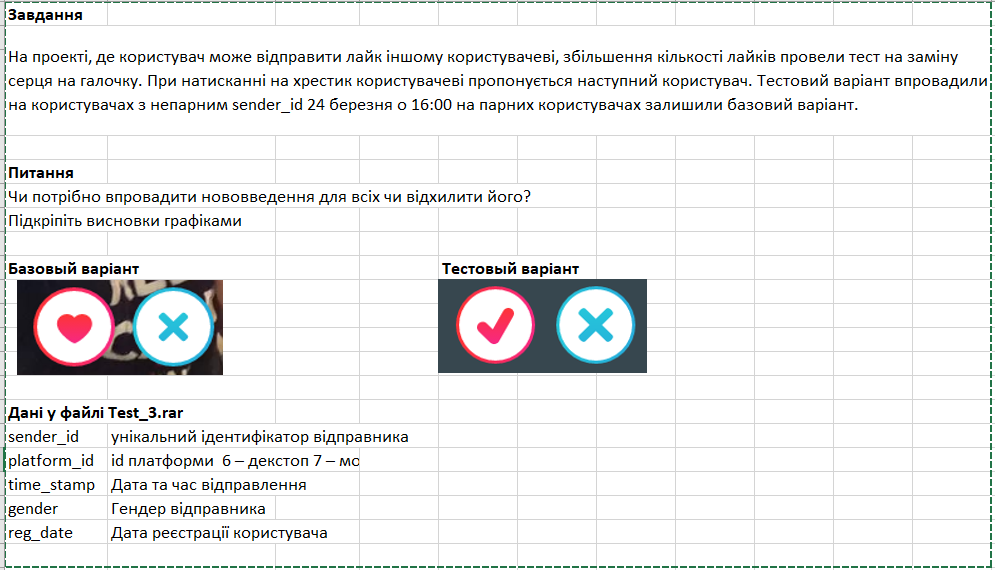

In [54]:
import pandas as pd
import scipy.stats as stats
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [21]:
data_path = '/content/drive/MyDrive/курс Аналітик/Test Tasks/Appflame/Test_3.csv'

In [22]:
df = pd.read_csv(data_path, sep=';')

In [29]:
df.head()

,sender_id,platform_id,time_stamp,gender,reg_date
0,3207526951,6,2017-03-16 13:35:00,m,26.01.2017
1,3207526951,6,2017-03-16 09:09:00,m,26.01.2017
2,3207526951,6,2017-03-16 09:09:00,m,26.01.2017
3,3207526951,6,2017-03-16 12:13:00,m,26.01.2017
4,3207526951,6,2017-03-15 14:01:00,m,26.01.2017


In [24]:
df['time_stamp'] = pd.to_datetime(df['time_stamp'], format='%d.%m.%Y %H:%M')

In [25]:
change_time = pd.to_datetime('24.03.2017 16:00', format='%d.%m.%Y %H:%M')

In [26]:
data_experiment = df[df['time_stamp'] >= change_time]

In [27]:
data_experiment

,sender_id,platform_id,time_stamp,gender,reg_date
150161,3218632174,7,2017-03-26 07:34:00,m,23.03.2017
150162,3218635027,7,2017-03-26 06:19:00,m,23.03.2017
150163,3218635027,7,2017-03-26 06:19:00,m,23.03.2017
150164,3218635027,7,2017-03-26 06:18:00,m,23.03.2017
150165,3218635027,7,2017-03-26 06:19:00,m,23.03.2017
...,...,...,...,...,...
729459,3219280750,6,2017-03-26 20:23:00,f,26.03.2017
729460,3219280834,7,2017-03-26 20:21:00,f,26.03.2017
729461,3219280834,7,2017-03-26 20:27:00,f,26.03.2017
729462,3219280834,7,2017-03-26 20:23:00,f,26.03.2017


In [30]:
control_group = data_experiment[data_experiment['sender_id'] % 2 == 0]
test_group = data_experiment[data_experiment['sender_id'] % 2 != 0]

In [31]:
control_likes = control_group.groupby('sender_id').size()
test_likes = test_group.groupby('sender_id').size()

In [81]:
control_likes

,0
sender_id,
3201946084,3
3201948046,21
3201948762,7
3201991474,16
3202014542,15
...,...
3219304194,18
3219304256,1
3219306778,1


Перевірю вибірки на нормальність

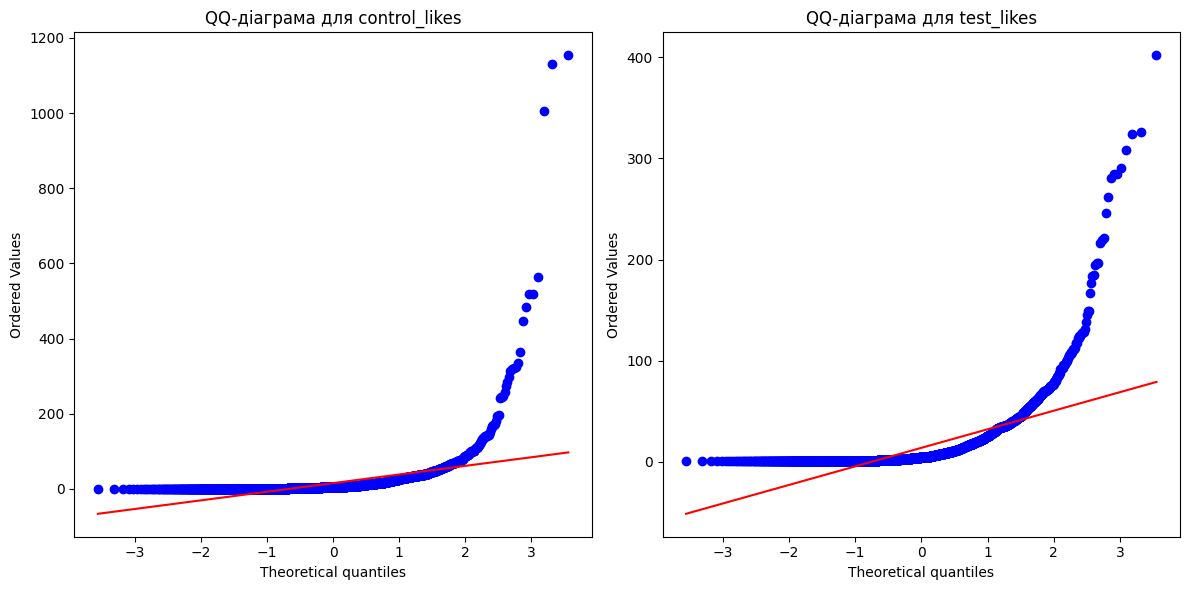

In [41]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
stats.probplot(control_likes, dist="norm", plot=plt)
plt.title("QQ-діаграма для control_likes")

plt.subplot(1, 2, 2)
stats.probplot(test_likes, dist="norm", plot=plt)
plt.title("QQ-діаграма для test_likes")

plt.tight_layout();

Обидва графіки (control_likes і test_likes) демонструють сильне відхилення від нормального розподілу.

Є довгі праві хвости — це означає, що є користувачі, які ставлять значно більше лайків, ніж решта.

Оскільки є багато точок, розташованих далеко від червоної лінії (яка показує теоретично нормальний розподіл) - дані не є нормально розподіленими

In [56]:
x_axis_control = np.arange(control_likes.min(), control_likes.max(), 0.01)
x_axis_test = np.arange(test_likes.min(), test_likes.max(), 0.01)

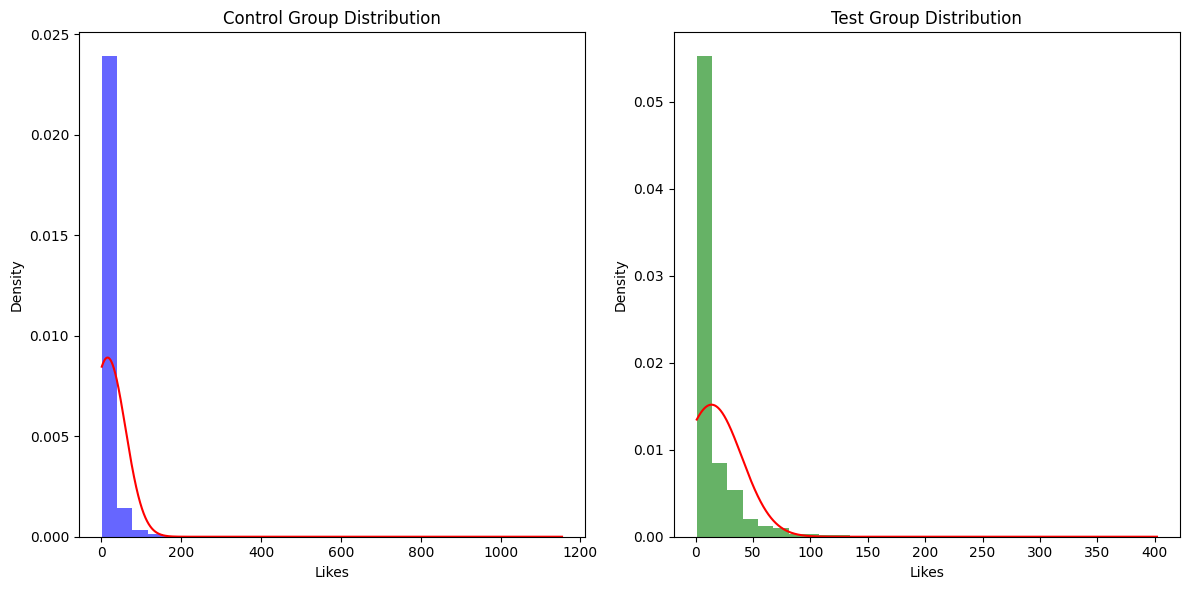

In [57]:
plt.figure(figsize=(12, 6))


plt.subplot(1, 2, 1)
plt.hist(control_likes, bins=30, density=True, alpha=0.6, color='b')
pdf_control = norm.pdf(x_axis_control, loc=np.mean(control_likes), scale=np.std(control_likes))
plt.plot(x_axis_control, pdf_control, 'r', label='Normal PDF')
plt.title('Control Group Distribution')
plt.xlabel('Likes')
plt.ylabel('Density')


plt.subplot(1, 2, 2)
plt.hist(test_likes, bins=30, density=True, alpha=0.6, color='g')
pdf_test = norm.pdf(x_axis_test, loc=np.mean(test_likes), scale=np.std(test_likes))
plt.plot(x_axis_test, pdf_test, 'r', label='Normal PDF')
plt.title('Test Group Distribution')
plt.xlabel('Likes')
plt.ylabel('Density')


plt.tight_layout();

Дана візуалізація також показує, що дані не є нормально роподіленими.

Оскільки 2 вибірки не є нормально розподіленими - використовую  U-тест Манна-Уітні

In [38]:

u_stat, p_value = stats.mannwhitneyu(test_likes, control_likes, alternative='two-sided')

print(f"U-тест Манна-Уітні: U-stat = {u_stat:.4f}, P-value = {p_value:.4f}")


if p_value < 0.05:
    print("Різниця статистично значуща. Нововведення слід впровадити.")
else:
    print("Різниця незначуща. Нововведення можна відхилити.")

U-тест Манна-Уітні: U-статистика = 6659900.0000, P-значення = 0.5045
Різниця незначуща. Нововведення можна відхилити.


Оскільки p-value > 0.05 - різниця незначуща, це означає, що заміна серця на галочку не вплинула суттєво на поведінку користувачів (кількість лайків не змінилася значущим чином).

Нововведення можна відхилити, оскільки немає доказів його ефективності.

Проведу ще z-test

In [111]:
std_control = control_likes.std()
std_test = test_likes.std()

In [96]:
n_control = len(control_likes)
n_test = len(test_likes)

In [97]:
mean_control = np.mean(control_likes)
mean_test = np.mean(test_likes)

In [99]:
z = (mean_control - mean_test) / np.sqrt((std_control**2 / n_control) + (std_test**2 / n_test))
p_value = 2 * (1 - stats.norm.cdf(abs(z)))

print(f"Z-stat: {z}")
print(f"P-value: {p_value}")

if p_value < 0.05:
    print("Різниця між групами статистично значуща.")
else:
    print("Різниця між групами не статистично значуща.")


Z-stat: 1.8899896392237427
P-value: 0.05875934576720221
Різниця між групами не статистично значуща.


Висновок:
Оскільки p-value > 0.05, ми не можемо відкинути нульову гіпотезу. Це означає, що різниця між контрольними та тестовими групами не є статистично значущою на рівні значущості 5%.

У цьому випадку немає достатньо статистичних доказів, щоб стверджувати, що тестова група має значно більше лайків на користувача в порівнянні з контрольною групою.

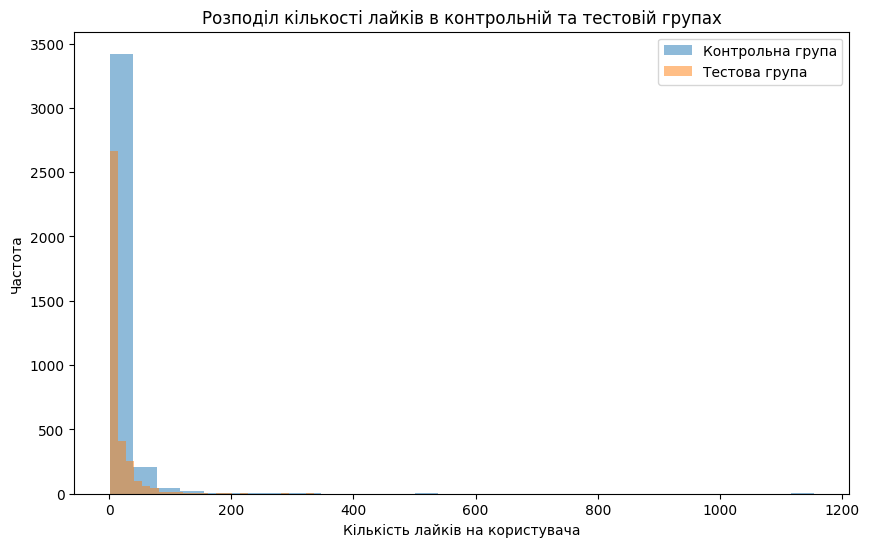

In [113]:
plt.figure(figsize=(10, 6))

plt.hist(control_likes, bins=30, alpha=0.5, label="Контрольна група")
plt.hist(test_likes, bins=30, alpha=0.5, label="Тестова група")

plt.title('Розподіл кількості лайків в контрольній та тестовій групах')
plt.xlabel('Кількість лайків на користувача')
plt.ylabel('Частота')
plt.legend();

Графік показує розподіл кількості лайків серед користувачів у контрольній групі та тестовій групі.

Обидві групи мають подібний розподіл лайків — більшість користувачів отримують невелику кількість лайків.
Розподіл є дуже асиметричним зі значною кількістю користувачів, які отримують мало лайків (близько до нуля), тоді як дуже мала частина користувачів отримує значно більше лайків.

Контрольна група демонструє трохи більшу кількість користувачів із низькою кількістю лайків у порівнянні з тестовою групою.

In [115]:
control_likes_df = pd.DataFrame({'likes': control_likes, 'group': ['Контрольна'] * len(control_likes)})
test_likes_df = pd.DataFrame({'likes': test_likes, 'group': ['Тестова'] * len(test_likes)})

In [116]:
combined_df = pd.concat([control_likes_df, test_likes_df])

<ipython-input-117-cb85db77749e>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='group', y='likes', data=combined_df, palette="Set2")


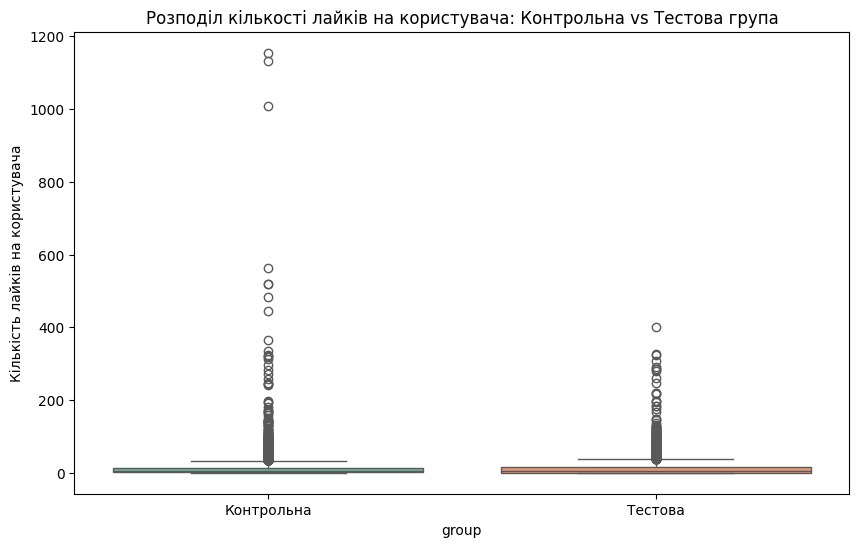

In [117]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='group', y='likes', data=combined_df, palette="Set2")

plt.title('Розподіл кількості лайків на користувача: Контрольна vs Тестова група')
plt.ylabel('Кількість лайків на користувача');

На графіку зображено boxplot, який показує розподіл кількості лайків на користувача у контрольній та тестовій групах.

У контрольній і тестовій групах медіана кількості лайків близька до нуля.
Основна частина користувачів у обох групах отримує дуже мало лайків

У контрольній групі спостерігається більше викидів із надзвичайно високою кількістю лайків (500–1200).
У тестовій групі також є викиди, але їхня кількість менша, а максимальні значення лайків нижчі, ніж у контрольній групі.

Контрольна група має більше користувачів із надзвичайно високою кількістю
лайків, що може свідчити про те, що тестова група не досягла такої ж активності.
Тестова група демонструє більш стабільний розподіл із меншою кількістю викидів, що може означати більш однорідну активність користувачів.